# EXERCISE-1

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score

# Load dataset
file_path = "Womens Clothing E-Commerce Reviews.csv"
df = pd.read_csv(file_path)

# Drop rows with missing Review Text
df = df.dropna(subset=["Review Text"])

# Remove products with fewer than 5 reviews
review_counts = df["Clothing ID"].value_counts()
df = df[df["Clothing ID"].isin(review_counts[review_counts >= 5].index)]

# Text Preprocessing
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\b(can't|cannot)\b", "can not", text)
    text = re.sub(r"\b(n't)\b", " not", text)
    text = re.sub(r"\b(i'm)\b", "i am", text)
    text = re.sub(r"\b('re)\b", " are", text)
    text = re.sub(r"\b('s)\b", " is", text)
    text = re.sub(r"\b('ll)\b", " will", text)
    text = re.sub(r"\b('ve)\b", " have", text)
    text = re.sub(r"\b('d)\b", " would", text)
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    return text

df["Cleaned Review"] = df["Review Text"].astype(str).apply(clean_text)

# Features (X) and Label (y)
X = df["Cleaned Review"]
y = df["Recommended IND"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Naïve Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred = nb_classifier.predict(X_test_tfidf)

# Evaluate model
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.8149
Recall: 1.0000
F1 Score: 0.8980


# EXERCISE-2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   State                                         51 non-null     object 
 1   Total.Rate                                    51 non-null     float64
 2   Total.Number                                  51 non-null     float64
 3   Total.Population                              51 non-null     float64
 4   Rates.Age.< 18                                51 non-null     float64
 5   Rates.Age.18-45                               51 non-null     float64
 6   Rates.Age.45-64                               51 non-null     float64
 7   Rates.Age.> 64                                51 non-null     float64
 8   Rates.Age and Sex.Female.< 18                 51 non-null     float64
 9   Rates.Age and Sex.Male.< 18                   51 non-null     float

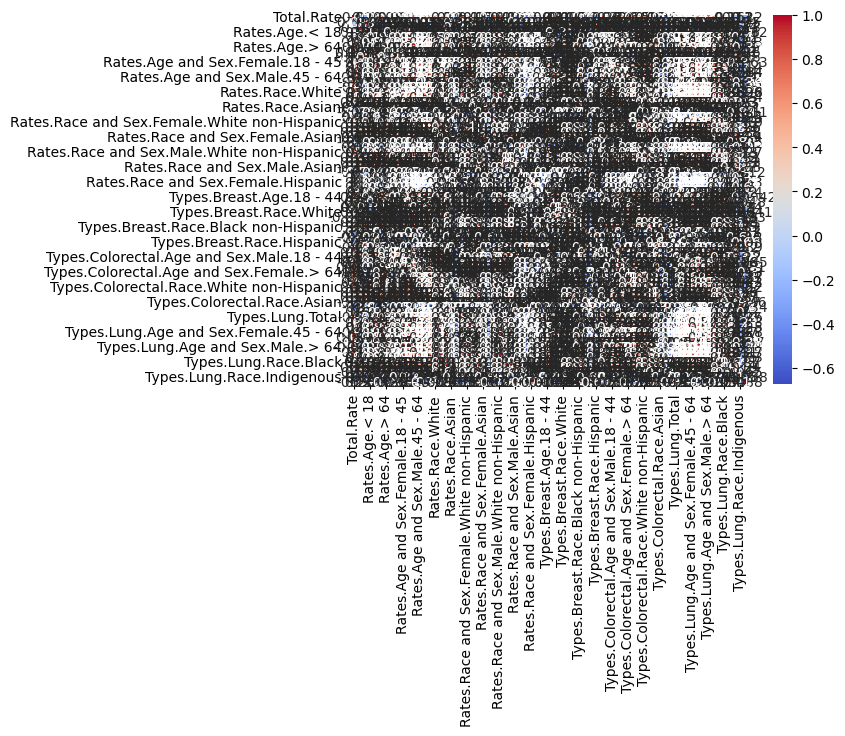

GaussianNB Results:
Precision: 0.7500
Recall: 1.0000
F1 Score: 0.8571
AUC-ROC: 0.9375

MultinomialNB Results:
Precision: 0.6667
Recall: 0.6667
F1 Score: 0.6667
AUC-ROC: 0.7708

BernoulliNB Results:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC-ROC: 0.5000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
file_path = "cancer.csv"
df = pd.read_csv(file_path)

# Explore dataset structure
print(df.info())
print(df.head())

# Handle missing values
df = df.dropna()

# Calculate correlation and remove highly correlated features
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

# Convert continuous variables into categorical bins if 'Age' exists
if 'Age' in df.columns:
    df['Age_Bin'] = pd.cut(df['Age'], bins=[0, 18, 45, 64, np.inf], labels=['<18', '18-45', '45-64', '>64'])
else:
    print("Warning: 'Age' column not found in dataset.")

# Apply PCA for dimensionality reduction
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.select_dtypes(include=[np.number]))
pca = PCA(n_components=5)
df_pca = pca.fit_transform(df_scaled)

# Create a binary target variable based on Total.Rate's third quartile threshold
if 'Total.Rate' in df.columns:
    threshold = df['Total.Rate'].quantile(0.75)
    df['Target'] = (df['Total.Rate'] > threshold).astype(int)
else:
    raise KeyError("'Total.Rate' column not found in dataset.")

# Select features for classification
selected_features = [
    'Rates.Age.< 18', 'Rates.Age.18-45', 'Rates.Age.45-64', 'Rates.Age.> 64',
    'Types.Lung.Race.White', 'Types.Lung.Race.Black', 'Types.Lung.Race.Hispanic'
]

# Ensure selected features exist in dataset
selected_features = [feat for feat in selected_features if feat in df.columns]
X = df[selected_features]
y = df['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naïve Bayes models
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    
    print(f"{name} Results:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}\n")
